<div class="alert alert-info">
    <h1><strong>2022 Cleveland In-Person Summer Camp Day 5 Lecture</strong></h1>
    <h2>VQE Chemistry Demo</h2>
</div>

In [38]:
# Imports!

# Base Qiskit
from qiskit import Aer, IBMQ
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import EfficientSU2

# Qiskit Nature
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.algorithms import GroundStateEigensolver

# Molecular Visualisation
from ase import Atoms
import ase.visualize

# Numpy amnd Plotting
import numpy as np
import matplotlib.pyplot as plt

# from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.load_account()
print("Libraries imported successfully")
%matplotlib widget

ibmqfactory.load_account:WARNING:2022-05-19 17:36:52,960: Credentials are already in use. The existing account in the session will be replaced.


Libraries imported successfully


# Defining the Molecule

In [2]:
def get_qubit_converter(dist):
    # Define the Molecule
    molecule = Molecule(
        geometry=[["H", [0.0, 0.0, 0.0]],
                  ["H", [0.0, 0.0, dist]]],
        charge=0, multiplicity=1)

    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
    )

    es_problem = ElectronicStructureProblem(driver)
    second_q_op = es_problem.second_q_ops()
    qubit_converter = QubitConverter(mapper=JordanWignerMapper())
    return (qubit_converter, es_problem)
# qubit_op = qubit_converter.convert(second_q_op[0])

In [3]:
def make_vqe_method():
    qsim = QuantumInstance(backend=Aer.get_backend('qasm_simulator')) #, noise_model = noise_model_belem)
    # This is the tunable circuit - this is the quantum part of VQE
    tunable_circuit = EfficientSU2(reps= 1, entanglement='full')
    # Classical optimizer - this is the classical part of VQE
    optimizer = COBYLA(maxiter=500)
    # Putting everything together using Qiskit's VQE function
    method = VQE(ansatz = tunable_circuit, optimizer = optimizer, quantum_instance = qsim)
    return method

In [17]:
def run_method(qubit_converter, es_problem, method):
    calc = GroundStateEigensolver(qubit_converter, method)
    result = calc.solve(es_problem)
    # Block 12 - Printing results
    return result.total_energies[0]

In [41]:
def make_plot(distances, classical_results, vqe_results):    
    fig,ax = plt.subplots(figsize = (8,6))
    ax.plot(distances, classical_results, label='Classical Energy of the molecule')
    ax.plot(distances, vqe_results, label='VQE Energy of the molecule')
    ax.set_xlabel('Distance between atoms (Angstrom)')
    ax.set_ylabel('Energy')
    ax.legend()
    return plt.show()

In [7]:
def visualize_best_molecule(result, distances):
    dist = distances[np.argmin(result)]
    s = ["H","H"]
    a = [[0.0, 0.0, 0.0], [0.0, 0.0, dist]]
    return ase.visualize.view(Atoms(positions=a, symbols=s), viewer="x3d")

Notes for instructor: much of the code is left above in functions. 
It may be useful to mention some of the steps in solving a chemistry problem with VQE, such as finding the shortest distance between molecules.

The cell below does most of the heavy lifting!

# Running VQE for Chemistry

In [18]:
# Result Store
classical_results, vqe_results = [], []
# Test Distances
distances = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1,2.3,2.5]

# Methods of solving
vqe_method = make_vqe_method()
classical_method = NumPyMinimumEigensolver()

# Loop across distances
for distance in distances:
    # Make the problem for a given molecule structure
    qubit_converter, es_problem = get_qubit_converter(distance)
    
    # Run both VQE and Classical solvers
    vqe_result = run_method(qubit_converter, es_problem, vqe_method)
    classical_result = run_method(qubit_converter, es_problem, classical_method)
    print(f"Classical energy: {classical_result}, VQE energy: {vqe_result}")
    
    vqe_results.append(vqe_result)
    classical_results.append(classical_result)

Classical energy: 2.7099607708672804, VQE energy: 2.7513158486843974
Classical energy: -0.6018037107656937, VQE energy: -0.5736734541505011
Classical energy: -1.055159794470627, VQE energy: -1.0382383424315893
Classical energy: -1.1361894540659274, VQE energy: -1.0900783244009462
Classical energy: -1.1205602812999873, VQE energy: -1.0799026890860823
Classical energy: -1.079192944969077, VQE energy: -1.0250157472219181
Classical energy: -1.0351862664342542, VQE energy: -0.9400002332164806
Classical energy: -0.9981493534714099, VQE energy: -0.7404978517085146
Classical energy: -0.971426688458341, VQE energy: -0.7724932719337548
Classical energy: -0.9543388539987285, VQE energy: -0.9334952570062629
Classical energy: -0.944374681119742, VQE energy: -0.6823668778705307
Classical energy: -0.9389223859872735, VQE energy: -0.9282320955517092
Classical energy: -0.9360549199556063, VQE energy: -0.9284300163019825


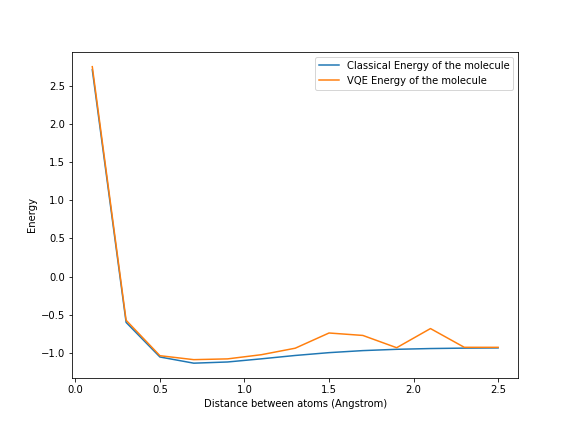

In [42]:
make_plot(distances, classical_results, vqe_results)

# This is the lowest energy bond length:
(You have to click and rotate)
N.B. We can only simulate small molecules like H2 on current quantum devices

In [43]:
visualize_best_molecule(vqe_results, distances)

# This is what we would like to be able to simulate!

In [44]:
# Show Bigger Molecule
symbols = ['C', 'C', 'C', 'N', 'C', 'O', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
 'H']

atoms = [[ 0.17581067,  1.32563015,  0.42497243],
 [-0.0691986, -0.14435865,  0.14087909],
 [ 0.99932871, -0.90573197, -0.61144798],
 [ 0.79264702, -1.12663036,  0.79949343],
 [ 1.74023067, -0.88228886,  1.77641842],
 [ 2.92146902, -1.10419001,  1.66514116],
 [-1.49027734, -0.61580452, -0.02605917],
 [-2.65733723,  0.13119212,  0.508544  ],
 [-2.4249456 ,  0.05310198, -0.94447741],
 [ 1.24688778,  1.54294186,  0.43428811],
 [-0.2809294,  1.95825083, -0.34329392],
 [-0.2397779,  1.62298927,  1.39238752],
 [ 0.71130635, -1.72165701, -1.26880949],
 [ 1.90341421, -0.37475399, -0.89892681],
 [ 1.27702931, -0.52106485,  2.7145009 ],
 [-1.55702391, -1.70076964, -0.06247784],
 [-3.52685753, -0.41453156,  0.86323691],
 [-2.48399094,  1.07662855,  1.01396676],
 [-2.02901992,  0.92808023, -1.27974128]]


ase.visualize.view(Atoms(positions=atoms, symbols=symbols), viewer="x3d")

### © 2022 The Coding School

**All rights reserved**

*Use of this activity is for personal use only. Copying, reproducing, distributing, posting or sharing this activity in any manner with any third party are prohibited under the terms of this registration. All rights not specifically licensed under the registration are reserved.*